# Quickstart to AutoPDEx

[Download this notebook](https://github.com/BodeTobias/AutoPDEx/tree/main/docs/notebooks/quickstart.ipynb)


In this example, let's do a finite element analysis of a hyperelastic mechanical punch problem:

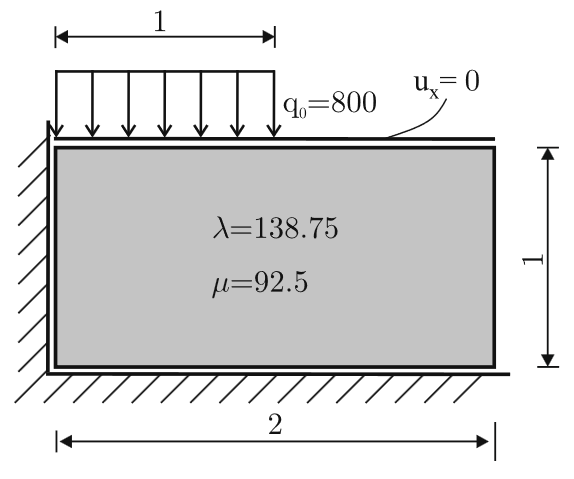

## Preprocessing

First, we do some imports and activate the double precision, since JAX is using single precsion by default.

In [1]:
import jax
from jax import config
import jax.numpy as jnp
import flax
import pygmsh
import meshio
import pyvista as pv

from autopdex import seeder, geometry, solver, utility, models, spaces

config.update("jax_enable_x64", True)


Meshing is (currently) not part of autopdex. Here we use pygmsh for the mesh generation. As element order we choose second order quadrilateral elements.


In [2]:
element_order = 2
L = 2.
H = 1.
pts = [[0., 0.], [L, 0.], [L, H], [0., H]]
with pygmsh.occ.Geometry() as geom:
    region = geom.add_polygon(pts, mesh_size=0.1)
    geom.set_recombined_surfaces([region.surface])
    mesh = geom.generate_mesh(order=element_order)


Let's get the relevant information from the mesh and make it to JAX arrays.

In [3]:
n_dim = 2
x_nodes = jnp.asarray(mesh.points[:,:n_dim])
n_nodes = x_nodes.shape[0]
elements = jnp.asarray([ v for k, v in mesh.cells_dict.items() if 'quad' in k])[0]
surface_elements = jnp.asarray([ v for k, v in mesh.cells_dict.items() if 'line' in k])[0]
print("Number of elements: ", elements.shape[0])
print("Number of unknowns: ", n_nodes * n_dim)

Number of elements:  241
Number of unknowns:  2050



For Finite Elements, the Dirichlet conditions are usually imposed by direct nodal imposition. Therefore, we first have to find the concerning nodes. The selection of nodes can be done by means of smooth distance functions. For some primitives, the distance function can be found in the geometry module. The module also contains Rvachev-function operations which can be used for constructing user-defined distance functions. Here, we select the nodes that are close to the lines on which we want to impose the Dirichlet boundary conditions.

In [4]:
dirichlet_nodes_left = geometry.on_lines(x_nodes, pts[0], pts[3])
dirichlet_nodes_bottom = geometry.on_lines(x_nodes, pts[0], pts[1])
dirichlet_nodes_top = geometry.on_lines(x_nodes, pts[2], pts[3])


For using the nodal imposition of boundary conditions in autopdex, we have to provide it with a mask that defines which degrees of freedoms shall be constrained.

Below, we fix the displacement in x-direction at the left and top and in y-direction at the bottom by settings the concerning entries to True.

In [5]:
selection_left = utility.dof_select(dirichlet_nodes_left, jnp.asarray([True, False]))
selection_bottom = utility.dof_select(dirichlet_nodes_bottom, jnp.asarray([False, True]))
selection_top = utility.dof_select(dirichlet_nodes_top, jnp.asarray([True, False]))
dirichlet_dofs = selection_left + selection_bottom + selection_top


Also, we have to provide the values of the Dirichlet conditions at the Dirichlet nodes. Here: homogeneous Dirichlet conditions.

In [6]:
dirichlet_conditions = jnp.zeros_like(dirichlet_dofs, dtype=jnp.float64)


For the imposition of the line load, we can use surface elements. First, the line elements for the Neumann boundary conditions are selected.

In [7]:
neumann_selection = geometry.select_elements_on_line(x_nodes, surface_elements, [0, H], [L/2, H])
neumann_elements= surface_elements[neumann_selection]


Now, we have to specify, how the element residual and tangent vectors shall be computed. Isoparametric domain elements based on a weak form are already contained in the models module, but we need to specify the solution space (spaces.fem_iso_line_quad_brick), the integration point positions and weights (Gauß-Legendre) and the weak form. The weak form for a hyperelastic mechanical steady state problem can also be loaded from the models (basically just $\frac{\partial \psi}{\partial \mathbf{F}} : \delta \mathbf{F}$, with the strain energy function $\psi$ and the deformation gradient $\mathbf{F}$). 

In [8]:
# Young's modulus and Poisson ratio
youngs_mod_fun = lambda x: 240.5
poisson_ratio = 0.3
poisson_ratio_fun = lambda x, settings: settings['poisson ratio']       # Here we take the Poisson ratio from the settings (and introduce the keyword 'poisson ratio') 
                                                                        # in order to be able to take the derivative with respect to the Poisson ratio later on

# Weak form with neo-Hookean strain energy function
weak_form_fun_1 = models.hyperelastic_steady_state_weak(
    models.neo_hooke, youngs_mod_fun, poisson_ratio_fun, 'plain strain')

# isoparametric Q2 elements with fourth order accurate Gauss integration
user_elem_1 = models.isoparametric_domain_element_galerkin(
    weak_form_fun_1, 
    spaces.fem_iso_line_quad_brick,
    *seeder.gauss_legendre_nd(dimension = 2, order = 2 * element_order))


Similarly, we can set-up the weak form contribution of the surface load ($- \mathbf{T} \cdot \delta \mathbf{u}$ with the traction $\mathbf{T}$). In order to be able to impose the traction in load steps, we have to multiply the load with the load multiplier.

In [9]:
q_0 = -8.0e+2
traction_fun = lambda x, settings: jnp.asarray([0., settings['load multiplier'] * q_0])
weak_form_fun_2 = models.neumann_weak(traction_fun)
user_elem_2 = models.isoparametric_surface_element_galerkin(weak_form_fun_2, 
                                                        spaces.fem_iso_line_quad_brick,
                                                        *seeder.gauss_legendre_nd(dimension = 1, order = 2 * element_order),
                                                        tangent_contributions=False)


Finally, we have defined the boundary value problem and have to put it in a form suitable for autopdex to proceed, i.e. the dictionaries static_settings and settings.


In [10]:
n_fields = 2
static_settings = flax.core.FrozenDict({
  'number of fields': (n_fields, n_fields),                 # In the tuples, we provide the information for the two domains, the volume and surface integral
  'assembling mode': ('user element', 'user element'),
  'solution structure': ('nodal imposition', 'nodal imposition'),
  'model': (user_elem_1, user_elem_2),
  'dirichlet dofs': utility.jnp_to_tuple(dirichlet_dofs),
  'connectivity': (utility.jnp_to_tuple(elements), utility.jnp_to_tuple(neumann_elements)),
  'solver type': 'newton',
  'solver backend': 'scipy',      # One could also use 'pardiso' (if installed) which is usually faster
  'solver': 'lapack',             # 'lu' in case of 'pardiso'
  'verbose': 1,
})

settings = {
  'load multiplier': 0.,
  'poisson ratio': poisson_ratio,
  'node coordinates': x_nodes,
  'dirichlet conditions': dirichlet_conditions,
}

## Analysis


Compile and run the adaptive load stepping.

In [11]:
dofs_0 = jnp.zeros((n_nodes, n_fields)) # Initial guess for the degrees of freedom
dofs = solver.adaptive_load_stepping(dofs_0, settings, static_settings)[0]


Multiplier: 0.2
Residual after Newton itteration 1: 30.12382634767878
Residual after Newton itteration 2: 7.484234761117217
Residual after Newton itteration 3: 0.8521793502482032
Residual after Newton itteration 4: 0.010471309029119018
Residual after Newton itteration 5: 1.831106619467243e-06
Residual after Newton itteration 6: 1.0063048206397892e-12

Multiplier: 0.4142857142857143
Residual after Newton itteration 1: 26.044600550086084
Residual after Newton itteration 2: 6.552331902727499
Residual after Newton itteration 3: 0.924562644528941
Residual after Newton itteration 4: 0.03481961828141885
Residual after Newton itteration 5: 5.320097906008942e-05
Residual after Newton itteration 6: 1.280873763608432e-10
Residual after Newton itteration 7: 3.0462434535856185e-12

Multiplier: 0.6285714285714286
Residual after Newton itteration 1: 21.84487496054915
Residual after Newton itteration 2: 3.0302573859327406
Residual after Newton itteration 3: 0.1712492491272352
Residual after Newton it


The adaptive_load_stepping function is automatically made differentiable with respect to the settings (currently execept the nodally imposed boundary conditions) by specifying the differentiation mode. Here, we exemplarily compute the derivative of the degrees of freedom with respect to the Poisson ratio. For taking derivatives of many values (dofs) with respect to a few variables (poisson ratio), the forward mode performs best.

In [12]:
static_settings = static_settings.copy({'verbose': -1})
@jax.jit
def diffable_solve(poisson_ratio, settings):
    settings['poisson ratio'] = poisson_ratio
    return solver.adaptive_load_stepping(dofs_0, settings, static_settings, path_dependent=False, implicit_diff_mode='forward')[0]
compute_sensitivities = jax.jit(jax.jacfwd(diffable_solve))
du_dnu = compute_sensitivities(poisson_ratio, settings)


In the first call, it is compiled. Subsequent calls are faster

In [13]:
%timeit -r 1 -n 1 diffable_solve(poisson_ratio, settings).block_until_ready()

14.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%timeit diffable_solve(poisson_ratio, settings).block_until_ready()

1.69 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Computing the sensitivity takes in this case only marginally longer

In [15]:
%timeit compute_sensitivities(poisson_ratio, settings).block_until_ready()

1.64 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Postprocessing


Export as .vtk for Paraview

In [16]:
points = mesh.points
cells = jnp.asarray([ v for k, v in mesh.cells_dict.items() if 'quad' in k])[0]
mesh = meshio.Mesh(
    points,
    {'quad': cells[:,:4]},
    point_data={
        "u": jnp.pad(dofs, ((0, 0), (0, 1)), constant_values=0),
        "du_dnu": jnp.pad(du_dnu, ((0, 0), (0, 1)), constant_values=0),
    },
)
mesh.write("./punch_test.vtk")


Visualization with pyvista

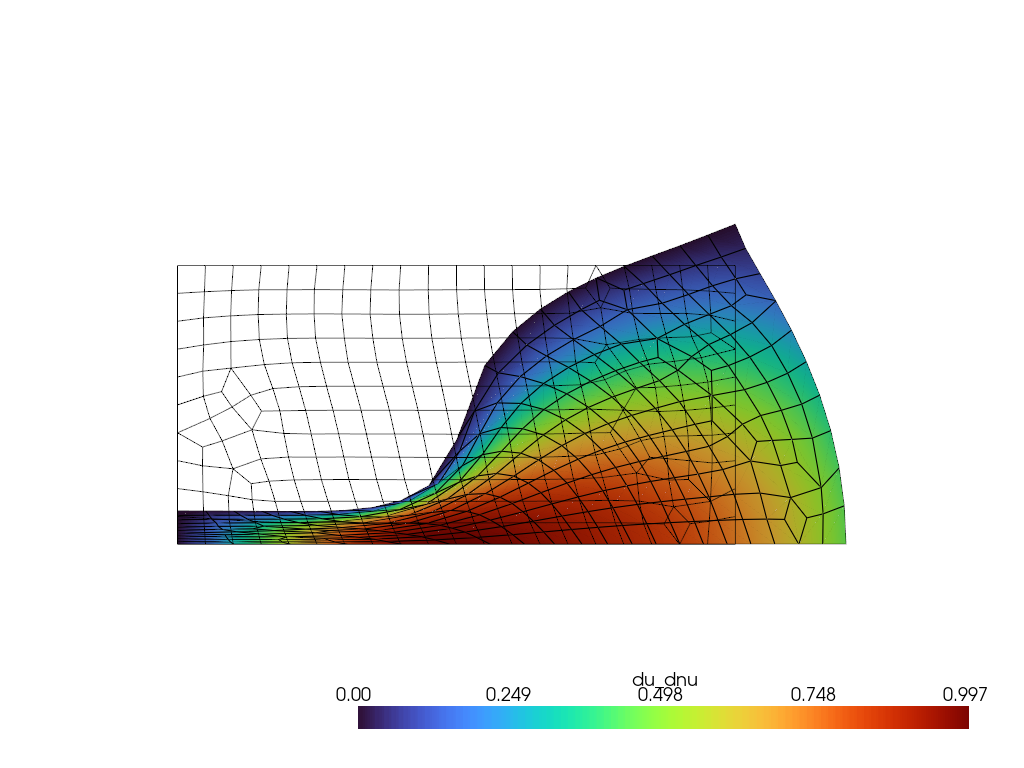

In [17]:
pv.set_jupyter_backend('static')
plotter = pv.Plotter()
pv_mesh = pv.read("./punch_test.vtk")
warped_mesh = pv_mesh.warp_by_vector('u')
plotter.add_mesh(warped_mesh, scalars='du_dnu', component=0, show_edges=True, cmap='turbo')
plotter.add_mesh(pv_mesh, style='wireframe', color='black')
plotter.view_xy()
plotter.show()